# Tutorial 1: A first OUU problem using the Poisson equation
In this tutorial we will:
- See a simple example for optimization under uncertainty, minimizing the mean of a quantity of interest for a Poisson PDE.
- Outline the basics components of SOUPy.

## Problem definition
We consider a Poisson equation on the domain $\Omega = (0,1)^2$,
\begin{align*}
\nabla \cdot (e^{m} \nabla u ) + z &= 0 \qquad x \in \Omega ,\\
u - x_2 &= 0 \qquad x \in \Gamma_D := \Gamma_{\text{top}} \cup \Gamma_{\text{bot}} ,\\
e^{m} \nabla u \cdot n &= 0 \qquad x \in \Gamma_N := \Gamma_{\text{left}} \cup \Gamma_{\text{right}} .
\end{align*}

Here $u$ is the PDE solution, $m$, the uncertain parameter, is the log-coefficient field, and $z$, the optimization variable, is a distributed source. We can often write this abstractly in a residual form, $R(u,m,z) = 0$. This has the weak formulation

$$
\text{Find } u \in \mathcal{U} \text{ s.t. } 
\int_{\Omega} e^m \nabla u \cdot \nabla v dx - \int_{\Omega} z v dx = 0 \qquad \forall v \in \mathcal{V}
$$

with the trial and test spaces 

\begin{align*}
\mathcal{U} &:= \{u \in H^1(\Omega) : u = x_2 \text{ on } \Gamma_{D} \} \\
\mathcal{V} &:= \{v \in H^1(\Omega) : v = 0 \text{ on } \Gamma_{D} \}
\end{align*}

We will also write the weak residual abstractly as $r(u,m,v,z) = 0$, where $v$ is the test function.

The log-coefficient $m$ is distributed as a Matern Gaussian random field, $m \sim \mathcal{N}(\bar{m}, \mathcal{C})$, where the covariance operator $\mathcal{C} = \mathcal{A}^{-2}$ is given by the squared-inverse of an elliptic operator 

$$
\mathcal{A} = -\gamma \Delta + \delta \mathcal{I}
$$

with Homogeneous Neumann boundary conditions. We will assume $(\gamma, \delta) = (0.5, 10)$ and $\bar{m} = -3$ is a constant.

The quantity of interest to minimize is the $L^{2}(\Omega)$ misfit between the state and a given target $u_d$, 

$$
Q(u,m,z) = \int_{\Omega} (u - u_d)^2 dx.
$$

Recall that the state $u$ can be obtained from the model parameter $m$ and optimization variable $z$, $u = u(m,z)$, by solving the PDE. Thus, $Q$ can be thought of as a random variable that is a push-forward of the distribution $\mathcal{N}(\bar{m}, \mathcal{C})$ through the mapping $Q = Q(u(m,z))$. 

We also consider a $L^2$-penalization (regularization) term for the control,

$$
P(z) := \alpha \int_{\Omega} z^2 dx,
$$

that accounts for the cost of applying the source, where $\alpha > 0$ is a weighting factor on the penalty. 

We can then formulate a simple OUU problem to minimize the expected value of $Q$ subject to the penalization and the PDE constraint:

$$
\min_{z \in L^2(\Omega)} \mathbb{E}[Q](z) + P(z) \qquad \text{s.t. } R(u,m,z) = 0
$$

To solve this problem, we need to approximate the expectation, which we do by a sample average. This gives the sample average approximation (SAA) optimization problem

$$
\min_{z \in L^2(\Omega)} \frac{1}{N} \sum_{i=1}^{N} Q(u_i, m_i, z)) + P(z) \qquad \text{s.t. } R(u_i,m_i,z) = 0 $$

that is, we sample realizations of $m_i \sim \mathcal{N}(\bar{m}, \mathcal{C})$ and solve the PDE to obtain samples of the state $u_i$ to evaluate the expected QoI. 

We will now go through to setup and solve this problem.

## 1. Import libraries 
Note: hippylib and soupy paths need to be appended if cloning the repos instead of installing via pip

In [1]:
import sys 
import os 
sys.path.append(os.environ.get('HIPPYLIB_PATH')) # Needed if using cloned repo
sys.path.append(os.environ.get('SOUPY_PATH')) # Needed if using cloned repo

import numpy as np 
import matplotlib.pyplot as plt 
import dolfin as dl 
import hippylib as hp 
import soupy 

## 2. Setup the function space
The function space and PDE formulation is similar to hIPPYlib. We create a function space for each of the state, parameter, and control/optimization variables. This is combined into a list with the ordering `[STATE, PARAMETER, ADJOINT, CONTROL]`, noting that the function space for the adjoint variable must be identical to that of the state. 

For simplicity, we will use $P_1$ finite elements for all of the function spaces. 

In [2]:
N_ELEMENTS_X = 20
N_ELEMENTS_Y = 20

mesh = dl.UnitSquareMesh(N_ELEMENTS_X, N_ELEMENTS_Y)

Vh_STATE = dl.FunctionSpace(mesh, "CG", 1)
Vh_PARAMETER = dl.FunctionSpace(mesh, "CG", 1)
Vh_CONTROL = dl.FunctionSpace(mesh, "CG", 1)
Vh = [Vh_STATE, Vh_PARAMETER, Vh_STATE, Vh_CONTROL] 

## 3. Define the PDE problem 
We now define a `soupy.PDEVariationalControlProblem` that represents the PDE. This is done by supplying the weak form of the residual $r(u,m,v,z)$. 

The `soupy.PDEVariationalControlProblem` constructs the PDE from: 
1. `Vh = [Vh_STATE, Vh_PARAMETER, Vh_ADJOINT, Vh_CONTROL]`
2. The residual form that can be called to the form the residual $r(u,m,v,z)$
3. Option lists of Dirichlet boundary conditions `bc` and their homogeneous (zeroed) counterparts `bc0`. Note: if no Dirichlet boundary conditions are used, empty lists are supplied by default (`bc = [], bc0 = []`). 
4. A flag `is_fwd_linear` denoting if the PDE is linear. This will be the case for us. If a nonlinear PDE is used, a nonlinear variational solver will be used to solve the PDE. 

In [3]:
def residual(u,m,v,z):
    return dl.exp(m)*dl.inner(dl.grad(u), dl.grad(v))*dl.dx - z * v *dl.dx 

def boundary(x, on_boundary):
    return on_boundary and (dl.near(x[1], 0) or dl.near(x[1], 1))

boundary_value = dl.Expression("x[1]", degree=1)

bc = dl.DirichletBC(Vh_STATE, boundary_value, boundary)
bc0 = dl.DirichletBC(Vh_STATE, dl.Constant(0.0), boundary)
pde = soupy.PDEVariationalControlProblem(Vh, residual, [bc], [bc0], is_fwd_linear=True)


## 4. Define the distribution for the random parameter
We will use hIPPYlib's `BiLaplacianPrior` to define the distribution for our uncertain log-coefficient field $m$. The `robin_bc` flag selects whether to use a Robin boundary condition for the elliptic operator $\mathcal{A}$. We will set it to false for simplicity.

Note that the function space passed in to this is just the parameter's function space.

In [4]:
PRIOR_GAMMA = 0.5
PRIOR_DELTA = 10.0
PRIOR_MEAN = -3.0

mean_vector = dl.interpolate(dl.Constant(PRIOR_MEAN), Vh_PARAMETER).vector()
prior = hp.BiLaplacianPrior(Vh_PARAMETER, PRIOR_GAMMA, PRIOR_DELTA, mean=mean_vector, robin_bc=False)

## 5. Define the optimization QoI
We define our optimization QoI $Q = \int_{\Omega} (u - u_d)^2$. 

Since this is a frequently used QoI, SOUPy has this implemented directly as `soupy.L2MisfitControlQoI`. 

Additionally, we can define QoIs as a `soupy.VariationalControlQoI` by supplying the variational form for $Q(u,m,z)$. We will use this approach in this tutorial.

We will pick a target state, say, 

$$
u_{d}(x_1, x_2) = x_2 + \cos(2\pi x_1) \sin(2 \pi x_2),
$$

which we can define using a FEniCS expression. We then write out a function `l2_qoi_form` that returns the variational form of the QoI


In [5]:
u_target = dl.Expression("x[1] + cos(k*x[0]) * sin(k*x[1])", k=2*np.pi, degree=2)

def l2_qoi_form(u,m,z):
    return (u - u_target)**2 * dl.dx 

qoi = soupy.VariationalControlQoI(Vh, l2_qoi_form)

## 6. Define the control model
We can now put the PDE with the QoI in a `soupy.ControlModel`. This essentially handles the entire mapping from $(m,z) \rightarrow u \rightarrow Q(u,m,z)$, along with the components for derivative computations.

In [6]:
control_model = soupy.ControlModel(pde, qoi)

## 7. Define the risk measure
We will use the expectation as risk measure with sample average approximation. This is implemented as a `soupy.MeanVarRiskMeasureSAA`, which gives a risk measure of the form

$$ \mathbb{E}[Q] + \beta \mathbb{V}[Q] $$ 

where $\beta > 0$ is a weighting on the variance. For this problem, we will just set $\beta = 0$. 

The sample size for the approximation and the variance weighting are supplied as settings. We will choose $N = 10$ to keep the runtime low. 

In [7]:
VARIANCE_WEIGHT = 0.0
SAMPLE_SIZE = 10

risk_settings = soupy.meanVarRiskMeasureSAASettings()
risk_settings["beta"] = VARIANCE_WEIGHT
risk_settings["sample_size"] = SAMPLE_SIZE 
risk_measure = soupy.MeanVarRiskMeasureSAA(control_model, prior, risk_settings)

## 8. Define the penalization 
We now define the $L^2$ penalization for the control variable. 

Once again, as this is commonly used, SOUPy provides the class `soupy.L2Penalization`. 

But as with the QoI, we can also define penalty terms by their variational forms using `soupy.VariationalPenalization`, so we will do that for the tutorial. We write the penalization as a function that returns the variational form $P(z)$ given $z$. 


In [8]:
PENALTY_WEIGHT = 1e-3

def l2_penalization_form(z):
    return dl.Constant(PENALTY_WEIGHT) * z**2 * dl.dx 

penalty = soupy.VariationalPenalization(Vh, l2_penalization_form)

## 9. Assemble the cost functional

With that, we can assemble the cost functional, which is a combination of the risk measure and the penalization

$$J(z) = \mathbb{E}[Q](z) + \mathbb{P}(z)$$

This is implemented as a `soupy.RiskMeasureControlCostFunctional` class. 

In [9]:
cost_functional = soupy.RiskMeasureControlCostFunctional(risk_measure, penalty)

## 10. Optimization 
We can now optimize the cost functional. In this tutorial, we will use the native SOUPy Inexact Newton CG algorithm, which makes use of the Hessian of the cost functional. The default settings use a backtracking line-search based globalization approach to find descent directions at every iteration. 

The optimizer is given an initial guess as a dolfin vector for the control variable $z$. A simple way of doing this is using the `generate_vector` method, which will return a zero vector corresponding to the function space of the given index (`soupy.STATE`, `soupy.PARAMETER`, `soupy.ADJOINT`, or `soupy.CONTROL`). **Note:** the default input is `'ALL'`, which will generate a list of vectors `x = [u,m,p,z]`, one for each variable.

The optimizer will then overwrite the input vector with the optimal solution. 

In [10]:
optimizer = soupy.InexactNewtonCG(cost_functional)
z = cost_functional.generate_vector(soupy.CONTROL)
optimizer.solve(z)


It  cg_it cost            (g,dz)          ||g||L2         alpha          
  1   2    1.369681e-02   -4.744559e-01    1.181035e-02    1.000000e+00    5.000000e-01
  2   3    1.248531e-02   -2.422989e-03    2.215114e-03    1.000000e+00    4.330785e-01
  3   6    1.205918e-02   -8.522694e-04    4.176918e-04    1.000000e+00    1.880600e-01
  4  23    1.197968e-02   -1.589976e-04    6.301921e-05    1.000000e+00    7.304745e-02
  5  38    1.197905e-02   -1.266265e-06    3.153411e-06    1.000000e+00    1.634025e-02
  6  67    1.197904e-02   -1.108209e-09    4.841012e-08    1.000000e+00    2.024588e-03


(<dolfin.cpp.la.PETScVector at 0x187e8d940>,
 {'termination_reason': 'Norm of the gradient less than tolerance',
  'final_cost': 0.011979044690015858,
  'final_grad_norm': 9.09264192227059e-11})

## 11. Visualization
We can now visualize our optimal control. In addition to plotting the distributed source, we can also sample from the random parameter field and plot their corresponding PDE solutions at the optimal control, and compare these to the target. 

We will start by generating a vector `x = [u,m,p,z]` which is a list containing a vector for each of the state, parameter, adjoint, and control variables.

Sampling from a `hippylib.BiLaplacianPrior` is done by first initializing a noise vector, filling it with Gaussian white noise, and then using the `prior` object to convert the noise vector to a parameter vector. Details can be found in the hIPPYlib documentation/tutorials.

We also set the `CONTROL` component of `x` to our optimal solution. Now `x` will have the sampled point `m` and the optimal control `z`





In [11]:
x = cost_functional.generate_vector()

# Initialize the noise vector 
noise = dl.Vector()
prior.init_vector(noise, "noise")

# Use hippylib's rng to sample Gaussian white noise 
rng = hp.Random(seed=111)

# This is sampling noise with 1.0 standard dev to the noise vector
rng.normal(1.0, noise) 

# The prior then turns the noise into a parameter sample
prior.sample(noise, x[soupy.PARAMETER])

# Also set the CONTROL component of x to the optimal control z
x[soupy.CONTROL].axpy(1.0, z)

We can now solve the PDE at the point `x`, i.e. the syntax is
`control_model.solvefwd(u, x)` 
which will solve the pde for the `m` and `z` stored in `x`, and will save the result to `u`. 

We'll simply save the result to the `u` stored in `x = [u, m, p, z]`

**Note:** `control_model.solveFwd` is a wrapper to `pde.solveFwd`.

In [12]:
control_model.solveFwd(x[soupy.STATE], x)

We can now plot the results. To facilitate this, we can convert them into dolfin functions first, and plot either using the hIPPYlib plotting capabilities or dolfin's built in plotting tools. We will use hIPPYlib's plotting tool. 

To plot the target state, we will also have to interpolate it first into the state's function space.

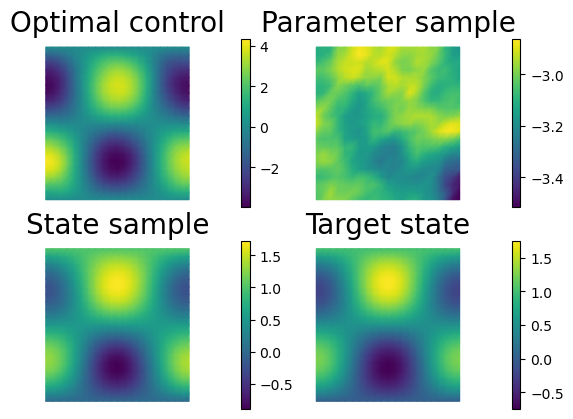

In [13]:
u_fun = dl.Function(Vh[soupy.STATE], x[soupy.STATE])
m_fun = dl.Function(Vh[soupy.PARAMETER], x[soupy.PARAMETER])
z_fun = dl.Function(Vh[soupy.CONTROL], x[soupy.CONTROL])
u_target_fun = dl.interpolate(u_target, Vh[soupy.STATE])


hp.nb.plot(z_fun, mytitle="Optimal control", subplot_loc=221)
hp.nb.plot(m_fun, mytitle="Parameter sample", subplot_loc=222)
hp.nb.plot(u_fun, mytitle="State sample", subplot_loc=223)
hp.nb.plot(u_target_fun, mytitle="Target state", subplot_loc=224)

For illustration, this last code block will repeat the sampling and forward solve. See how the Sample state will vary depending on the parameter, and recall that OUU problem only aims to be optimal in expectation.

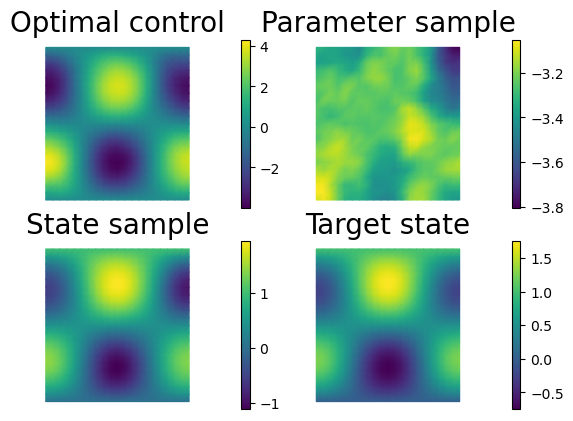

In [14]:
rng.normal(1.0, noise)
prior.sample(noise, x[soupy.PARAMETER])
control_model.solveFwd(x[soupy.STATE], x)

u_fun = dl.Function(Vh[soupy.STATE], x[soupy.STATE])
m_fun = dl.Function(Vh[soupy.PARAMETER], x[soupy.PARAMETER])
z_fun = dl.Function(Vh[soupy.CONTROL], x[soupy.CONTROL])
u_target_fun = dl.interpolate(u_target, Vh[soupy.STATE])


hp.nb.plot(z_fun, mytitle="Optimal control", subplot_loc=221)
hp.nb.plot(m_fun, mytitle="Parameter sample", subplot_loc=222)
hp.nb.plot(u_fun, mytitle="State sample", subplot_loc=223)
hp.nb.plot(u_target_fun, mytitle="Target state", subplot_loc=224)